# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

### Mounting Google drive 
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [88]:
from google.colab import drive 
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Load the "images.npy" file 
- This file contains images with details of bounding boxes

In [89]:
import numpy as np
data = np.load('/content/drive/MyDrive/k/images.npy',allow_pickle=True)

## Use Tensorflow
## set Random seed

In [90]:
import tensorflow as tf
tf.__version__

np.random.seed(42)
tf.random.set_seed(42)

### Check one sample from the loaded "images.npy" file  

In [91]:
print(data[0])

[array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)
 list([{'label': ['Face'], 'notes': '', 'points': [{'x': 0.08615384615384615, 'y': 0.306306

In [92]:
data.shape

(409, 2)

### Set image dimensions   
- Initialize image height, image width with value: 224 

In [93]:
IMAGE_HEIGHT = 224 
IMAGE_WIDTH = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [94]:
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input

masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [95]:
print(X.shape)

(409, 224, 224, 3)


In [96]:
print(masks.shape)

(409, 224, 224)


### Split the data into training and testing 
- 400 images in training
- 9 images in testing data

Training data

In [97]:
X_train = X[:400]
y_train = masks[:400]

In [98]:
X_train.shape

(400, 224, 224, 3)

In [99]:
y_train.shape

(400, 224, 224)

Testing data

In [100]:
X_test =X[400:]
y_test = masks[400:]

In [101]:
X_test.shape

(9, 224, 224, 3)

In [102]:
y_test.shape

(9, 224, 224)

### Print a sample training image, image array and its mask 

Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


array([[[ 0.59215689,  0.73333335,  0.62352943],
        [ 0.5529412 ,  0.69411767,  0.58431375],
        [ 0.43529415,  0.63921571,  0.53725493],
        ...,
        [-0.89803922, -0.81960785, -0.88235295],
        [-0.86666667, -0.81176472, -0.86666667],
        [-0.85882354, -0.80392158, -0.85882354]],

       [[ 0.5529412 ,  0.69411767,  0.58431375],
        [ 0.53725493,  0.67843139,  0.56862748],
        [ 0.41176474,  0.6156863 ,  0.51372552],
        ...,
        [-0.90588236, -0.82745099, -0.89019608],
        [-0.90588236, -0.8509804 , -0.90588236],
        [-0.90588236, -0.8509804 , -0.90588236]],

       [[ 0.56078434,  0.7019608 ,  0.59215689],
        [ 0.54509807,  0.68627453,  0.57647061],
        [ 0.41176474,  0.60784316,  0.50588238],
        ...,
        [-0.89019608, -0.81176472, -0.87450981],
        [-0.88235295, -0.82745099, -0.88235295],
        [-0.89019608, -0.83529413, -0.89019608]],

       ...,

       [[-0.80392158, -0.64705884, -0.70980394],
        [-0

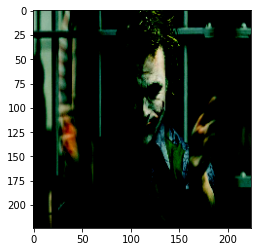

In [103]:
import matplotlib.pyplot as plt
plt.imshow(X_train[165])    
X_train[165]

Print the mask

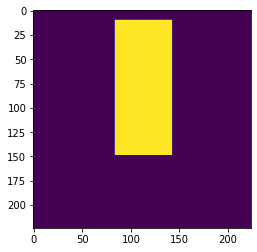

In [104]:
plt.imshow(masks[165].reshape(224,224))

## Create the model 
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
- Build the model for image segmentation
- output a probability response map

In [105]:
import tensorflow
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Reshape, UpSampling2D, Concatenate, Conv2D,Input,Activation,BatchNormalization,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [106]:
def create_model(trainable = True):
  inputs = Input(shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3),name = 'input_image')

  # pre-trained network
  encoder = MobileNet(input_tensor = inputs,input_shape= (IMAGE_HEIGHT, IMAGE_WIDTH, 3) ,include_top=False, alpha=1.0, weights="imagenet")
  skip_connections = ["conv_pw_5_relu","conv_pw_3_relu","conv_pw_1_relu","input_image"]
  encoder_output = encoder.get_layer("conv_pw_11_relu").output

    
  f = [112,56,28,14]
  x = encoder_output
  for i in range (len(skip_connections)):
    x_skip = encoder.get_layer(skip_connections[i]).output
    x = UpSampling2D((2,2))(x)
    x = Concatenate()([x,x_skip])
    
    x = Conv2D(f[i], (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
        
    x = Conv2D(f[i], (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

  x = Conv2D(1, (1, 1), padding="same")(x)
  x = Activation("sigmoid")(x)
  x = Reshape((IMAGE_HEIGHT,IMAGE_WIDTH))(x)
   
  create_model = Model(inputs,x)
  
  for layer in create_model.layers[0:70]:
    layer.trainable = trainable
  return create_model

### Call the create_model function 
-Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [107]:
model = create_model(trainable=False)

### Print model summary

In [108]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
____________________________________________________________________________________________

### Define dice coefficient function
- Create a function to calculate dice coefficient


In [109]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

### Define loss function 

In [110]:
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tensorflow.keras.backend.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### Compile the model 
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

In [111]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy

optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer=optimizer, metrics=[dice_coefficient])

### Define callbacks
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [112]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint("/content/drive/MyDrive/k/segmentation/checkpoint/", monitor="val_loss", verbose=1, save_best_only=False, save_weights_only=True,save_freq=100)

stop = EarlyStopping(monitor="val_loss", patience=5)

reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)

### Fit the model
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [113]:
model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs=30, batch_size=1,verbose=1,callbacks=[stop,checkpoint,reduce_lr])

Epoch 1/30
 96/400 [======>.......................] - ETA: 3s - loss: 2.7431 - dice_coefficient: 0.2209
Epoch 00001: saving model to /content/drive/MyDrive/k/segmentation/checkpoint/
196/400 [=============>................] - ETA: 2s - loss: 2.4438 - dice_coefficient: 0.2615
Epoch 00001: saving model to /content/drive/MyDrive/k/segmentation/checkpoint/
298/400 [=====================>........] - ETA: 1s - loss: 2.2859 - dice_coefficient: 0.2799
Epoch 00001: saving model to /content/drive/MyDrive/k/segmentation/checkpoint/
400/400 [==============================] - ETA: 0s - loss: 2.1703 - dice_coefficient: 0.2947
Epoch 00001: saving model to /content/drive/MyDrive/k/segmentation/checkpoint/
400/400 [==============================] - 8s 14ms/step - loss: 2.1693 - dice_coefficient: 0.2948 - val_loss: 1.6260 - val_dice_coefficient: 0.3214
Epoch 2/30
 99/400 [======>.......................] - ETA: 2s - loss: 1.5055 - dice_coefficient: 0.3680
Epoch 00002: saving model to /content/drive/MyDri

### Get the predicted mask for a test image  

Show the test image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


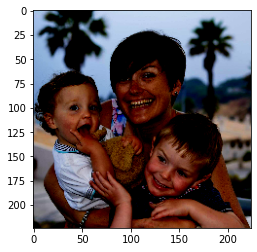

In [131]:
plt.imshow(X_test[0])

Show original mask for test image

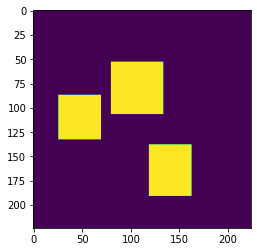

In [115]:
plt.imshow(y_test[0])

Predict the mask on the test image

In [116]:
#Predict on test set
preds_val = model.predict(X_test, verbose=1)

1/1 [==============================] - 0s 469ms/step


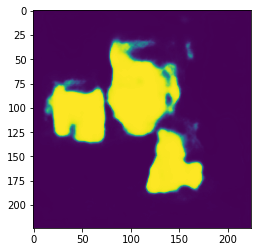

In [132]:
plt.imshow(preds_val[0])

### Impose the mask on the test image 
- In imshow use the alpha parameter and set it to greater than 0.5

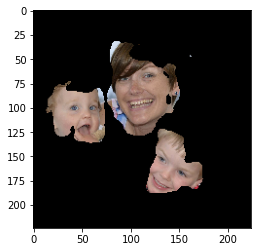

In [118]:
# This step is important because `X_test[2]` pixel values are between 0 and 1  and we want to restore the original input image  
test_img = np.array(
    tensorflow.keras.preprocessing.image.array_to_img(X_test[0])
)

# Doing the same operation on the mask 
mask=np.uint8(preds_val[0]*255)

# Now in the new mask, values are now between 0 and 255 (they doesn't reach 255)
# So  we need to make all the bright pixels ( pixel having values > 180) equal to 255 and and the dark pixels ( pixels having values < 120) equal to 0
mask[mask >= 180] = 255
mask[mask <= 120] = 0

# Now we will apply the mask to the image to make it only show the faces in the image
masked_image = cv2.bitwise_and(test_img, test_img, mask=mask)
plt.imshow(masked_image)

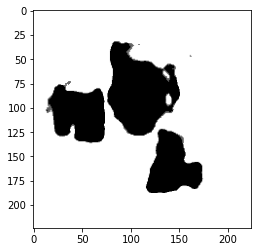

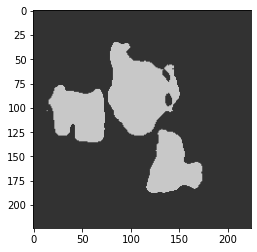

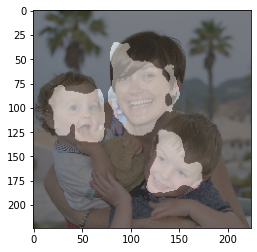

In [119]:
# The original mask is for the faces only, so if we want to mask the background, we need to invert this mask
bg_mask = cv2.bitwise_not(mask)

plt.figure()
plt.imshow(bg_mask, cmap="gray")

alpha = 0.6 #! closer to one will have more saturation (more obequie) 

# This is the overlay  we will apply to our input image to make the background a little bit darker, Note that it should have the  dimensions of the original image
overlay = np.zeros((*bg_mask.shape, 3), dtype="uint8")

# Now we will loop over the channels of the ovelay "RGB channels". Then, in each chanel we will make the background pixels dark (equal to 50) and the faces more bright (equal to 200)
for i in range(3):
  overlay[:, :, i][bg_mask!=0] = 50
  overlay[:, :, i][bg_mask==0] = 200

# The final step is to use this method to put the overlay over our original test image
final = cv2.addWeighted(overlay, alpha, test_img, 1 - alpha, 0,)

plt.figure()
plt.imshow(overlay)

plt.figure()
plt.imshow(final)